# Introduction

This Notebook gives a quick overview of the capabilities of the visiualisation module.

- Easy drawing of plain geometric primitives (rectangles, circles)
- Easy access to interactions (useful for kinematic visualisation)
- Easy access to animation generation (time-dependent functions and configuration space)

In [1]:
%load_ext ipydex.displaytools
import sympy as sp
from sympy import sin, cos
import numpy as np
import scipy.integrate
import symbtools as st
import symbtools.modeltools as mt
import matplotlib.pyplot as plt
import symbtools.visualisation as vt
sp.init_printing()

import importlib

In [2]:
theta1, theta2 = theta = st.symb_vector('theta1:3')
dtheta1, dtheta2 = dtheta = st.time_deriv(theta, theta)
tau = sp.symbols('tau')
params = st.symb_vector('m1 l1 J1 mu1 m2 r2 J2 mu2')
st.make_global(params)

In [3]:
p0 = sp.Matrix([0, 0])
p1 = sp.Matrix([l1/2*cos(theta1), l1/2*sin(theta1)])
p2 = sp.Matrix([l1*cos(theta1), l1*sin(theta1)])
p3 = p2 + sp.Matrix([r2*cos(theta1+theta2), r2*sin(theta1+theta2)])
dp1 = st.time_deriv(p1, theta)
dp2 = st.time_deriv(p2, theta)

In [4]:
T_rot = J1 * dtheta1**2 / 2 + J2 * (dtheta1 + dtheta2)**2 / 2
T_trans = (m1 * dp1.T * dp1 / 2 + m2 * dp2.T * dp2 / 2)[0]
T = T_rot + T_trans
V = 0
friction1 = dtheta1 * mu1
friction2 = dtheta2 * mu2

model = mt.generate_symbolic_model(T, V, theta, [0 - friction1, tau - friction2])
model.tau = [tau]
model.calc_state_eq()

f = model.f
g = model.g

In [5]:
m1_val = 0.1
m2_val = 1
l1_val = 0.5
r2_val = 0.2
J1_val = 1/12 * m1_val * l1_val**2
J2_val = 1/2 * m2_val * r2_val**2
mu1_val = 0.01
mu2_val = 0.001

param_subs = st.lzip(params, [m1_val, l1_val, J1_val, mu1_val, m2_val, r2_val, J2_val, mu2_val])

f_fun = st.expr_to_func(model.x, f.subs(param_subs))
g_fun = st.expr_to_func(model.x, g.subs(param_subs))

def tau_fun(t, x):
    return np.sin(2*np.pi*0.25*t)

def ode_fun(t, x):
    return f_fun(x[0], x[1], x[2], x[3]) + tau_fun(t, x) * g_fun(x[0], x[1], x[2], x[3])

x_init = np.array([0, 0, 0, 2])
tf = 1.0
dt = 1/30
ts = np.arange(0.0, tf, dt)
samples = len(ts)
ys = np.empty((samples, len(model.x)))
ys[0, :] = x_init

# get state trajectory
for i in range(samples - 1):
    result = scipy.integrate.solve_ivp(ode_fun, (ts[i], ts[i+1]), ys[i, :])
    ys[i+1, :] = result.y[:, -1]
    
# get input trajectory after the fact
us = np.empty((samples, 1))
for i in range(samples):
    us[i, 0] = tau_fun(ts[i], ys[i, :])

In [6]:
importlib.reload(vt)

<module 'symbtools.visualisation' from '/media/workcard/workstickdir/projekte/rst_python/symbtools-TUD-RST-Account/symbtools/visualisation.py'>

In [7]:
vis = vt.Visualiser(theta, xlim=(-1, 1), ylim=(-1, 1))
vis.add_linkage([p0.subs(param_subs), p2.subs(param_subs)])
vis.add_disk([p2.subs(param_subs), p3.subs(param_subs)], color="red")

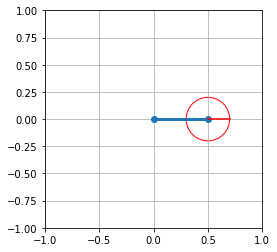

In [8]:
vis.plot([0.0, 0.0])

In [9]:
vis.interact(theta2=(-3.14, 3.14, 0.01))

interactive(children=(FloatSlider(value=0.0, description='theta1', max=5.0, min=-5.0), FloatSlider(value=0.0, …

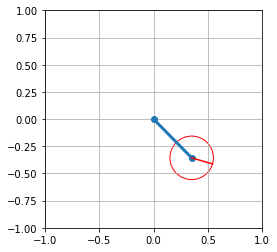

In [10]:
simanim = vt.SimAnimation(model.x, ts, ys)
simanim.add_visualiser(vis)
simanim.display_frame()

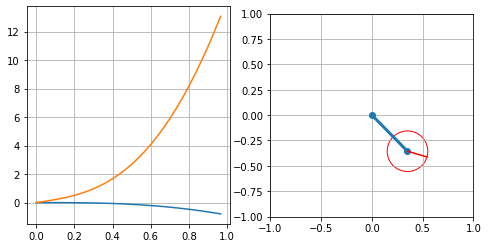

In [11]:
simanim = vt.SimAnimation(model.x, ts, ys, figsize=(8, 4))
simanim.add_visualiser(vis, 122)
simanim.add_graph(theta, 121)
simanim.display_frame()

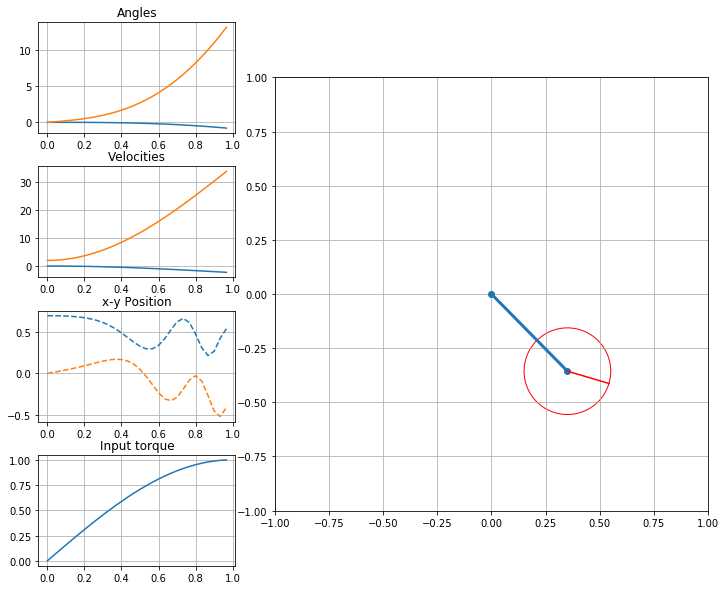

In [12]:
from matplotlib.gridspec import GridSpec

gs = GridSpec(4, 3, hspace=0.3)

simanim = vt.SimAnimation(model.x, ts, ys, start_pause=0.5, end_pause=0.5, figsize=(12, 10))
simanim.add_visualiser(vis, gs[:, 1:])
simanim.add_graph(theta, gs[0, 0], ax_kwargs=dict(title='Angles')) # most common options can probably be exposed easier
simanim.add_graph([dtheta1, dtheta2], gs[1, 0], ax_kwargs=dict(title='Velocities'))
simanim.add_graph(p3.subs(param_subs), gs[2, 0], ax_kwargs=dict(title='x-y Position'), plot_kwargs=dict(ls='--'))
simanim.add_graph(us[:, 0], gs[3, 0], ax_kwargs=dict(title='Input torque'))
simanim.display_frame()  # render just one frame to check the layout

In [13]:
# simanim.display()  # show the whole animation (increases filesize of jupyter notebook)

In [14]:
# this probably needs to be adapted on other systems
# (anaconda version of ffmpeg might lead to an error)

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

fname = 'demo_animation.mp4'
simanim.save(fname, dpi=50)  # save to file

In [15]:
vt.display_video_file(fname)